# Generative Adversarial Networks (GANs)


## Generando contenido con GANs

Imaginemos el siguiente juego; dos individuos, un destacado falsificador conocido por producir los mejores billetes falsos jamás fabricados, y por otro lado, un policía, que se encarga de identificar si el dinero que circula es real o falso. Vaya obra, ¿no? Podemos elegir a Tom y Leo para la película, ¿verdad?

Ahora bien, ¿cómo se relaciona esto con el Machine Learning, el Deep Learning o cualquier tipo de Aprendizaje Automatizado conocido por la humanidad?

La promesa del aprendizaje profundo es descubrir modelos jerárquicos ricos que representen distribuciones de probabilidad sobre los tipos de datos encontrados en aplicaciones de inteligencia artificial, como imágenes naturales, formas de onda de audio que contienen voz y símbolos, entre otros. Soñamos con implementaciones de Deep Learning que puedan crear contenido por sí mismas y que, amigos míos, sean parte de este viaje.

Recién estamos comenzando, pero los resultados de diferentes artículos e investigadores son prometedores. Sin embargo; Comencemos con algo relativamente simple que nos ayudará a comprender cómo funcionan las soluciones de Deep Learning que pueden “Crear” contenido. Es por eso que presentaremos a nuestro personaje principal, las Redes Generativas Adversariales (GAN).

Las "Generative Adversarial Networks" son un tipo de redes neuronales que han ganado mucha popularidad en los últimos años debido a su capacidad para generar contenido nuevo de alta calidad.



La idea es realmente sencilla:

<img src="http://2018.igem.org/wiki/images/4/48/T--Vilnius-Lithuania-OG--introduction1.png">

El modelado generativo implica el uso de un modelo que tiene como objetivo crear.

Es probable que nuevos ejemplos provengan de una distribución existente de muestras pero, a su vez, será diferente de una población de instancias existente, por lo que son falsas (sintéticas).

Una GAN se entrena a partir de dos modelos de arquitectura de red. Un generador (nuestro falsificador) que aprende a crear nuevas muestras y un discriminador (nuestra policía) que aprende a identificar instancias reales/falsas.

El objetivo de una GAN es que el nuevo contenido generado a partir del ruido en la entrada es lo suficientemente realista como para confundir al discriminador.

### ¿Cómo funcionan las GANs?
- El generador (“falsificador”) trata de generar contenido lo suficientemente realista como para engañar al discriminador (“policía”)

- El discriminador trata de distinguir el contenido real del falso ¡Compiten entre ellos! → inestabilidad :(


### ¿Cómo se entrenan las GANs?


El entrenamiento ocurre en 2 fases:
- El discriminador recibe imágenes reales y falsas, con las etiquetas correspondientes (0 para las falsas y 1 para las reales), y debe aprender a predecir correctamente. Cuando se equivoca,sus pesos se actualizan.

- Con los pesos del discriminador congelados, el generador introduce imágenes generadas con etiqueta “real” (1) al discriminador. Cuando el discriminador predice que la imagen es falsa, al no coincidir la etiqueta con la predicción, se genera un error que permite actualizar los pesos del generador para que aprenda a sintetizar imágenes más realistas.


Después del entrenamiento, el modelo generativo podrá crear nuevas muestras sintéticas y el discriminador debería poder identificar entradas reales y falsas bajo demanda.

In [ ]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
from tensorflow.keras.optimizers.legacy import Adam
import tensorflow as tf
import time
from IPython import display

### Cargar y preparar el conjunto de datos.

Utilizará el conjunto de datos MNIST para entrenar el generador y el discriminador. El generador generará dígitos escritos a mano que se asemejan a los datos MNIST.

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [ ]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [ ]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### Crear los modelos

Tanto el generador como el discriminador se definen mediante la [API Keras Sequential](https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fwww.tensorflow.org%2Fguide%2Fkeras%23sequential_model).


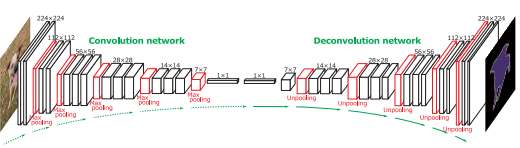

### El generador

El generador utiliza capas `tf.keras.layers.Conv2DTranspose` (muestreo ascendente) para producir una imagen a partir de una semilla (ruido aleatorio). Comience con una capa Densa que tome esta semilla como entrada, luego aumente la muestra varias veces hasta alcanzar el tamaño de imagen deseado de `28x28x1`. Observe la activación `tf.keras.layers.LeakyReLU` para cada capa, excepto la capa de salida que usa `tanh`.


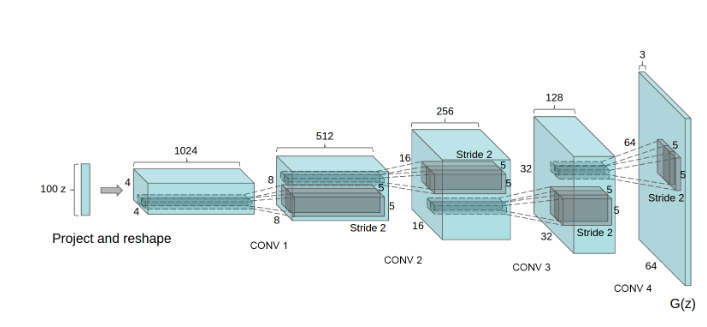

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

Utilice el generador (aún no capacitado) para crear una imagen.

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### El discriminador

El discriminador es un clasificador de imágenes basado en CNN.

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Utilice el discriminador (aún no entrenado) para clasificar las imágenes generadas como reales o falsas. El modelo será entrenado para generar valores positivos para imágenes reales y valores negativos para imágenes falsas.

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

### Definir la pérdida y los optimizadores.

Defina funciones de pérdida y optimizadores para ambos modelos.

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Pérdida discriminadora (Discriminator loss)

Este método cuantifica qué tan bien el discriminador es capaz de distinguir imágenes reales de falsas. Compara las predicciones del discriminador sobre imágenes reales con una matriz de unos, y las predicciones del discriminador sobre imágenes falsas (generadas) con una matriz de ceros.

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Pérdida del generador (Generator loss)

La pérdida del generador cuantifica qué tan bien pudo engañar al discriminador. Intuitivamente, si el generador funciona bien, el discriminador clasificará las imágenes falsas como reales (o 1). Aquí, compare las decisiones de los discriminadores sobre las imágenes generadas con una matriz de unos.

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Los optimizadores discriminador y generador son diferentes ya que entrenará dos redes por separado.

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Guardar puntos de control (Save checkpoints)

Este cuaderno también muestra cómo guardar y restaurar modelos, lo que puede resultar útil en caso de que se interrumpa una tarea de entrenamiento de larga duración.

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

El ciclo de entrenamiento comienza cuando el generador recibe una semilla aleatoria como entrada. Esa semilla se utiliza para producir una imagen. Luego, el discriminador se utiliza para clasificar imágenes reales (extraídas del conjunto de entrenamiento) e imágenes falsas (producidas por el generador). La pérdida se calcula para cada uno de estos modelos y los gradientes se utilizan para actualizar el generador y el discriminador.

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

Generar y guardar imágenes

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

### Entrenar el modelo

Llame al método train() definido anteriormente para entrenar al generador y al discriminador simultáneamente. Tenga en cuenta que entrenar GAN puede resultar complicado. Es importante que el generador y el discriminador no se dominen entre sí (por ejemplo, que entrenen a un ritmo similar).

Al comienzo del entrenamiento, las imágenes generadas parecen ruido aleatorio. A medida que avance el entrenamiento, los dígitos generados parecerán cada vez más reales. Después de aproximadamente 50 épocas, se parecen a los dígitos MNIST. Esto puede tardar aproximadamente un minuto por época con la configuración predeterminada en Colab.

In [ ]:
train(train_dataset, EPOCHS)

Restauramos el último checkpoint

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

### Creamos un GIF

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCHS)

Usamos `imageio` para crear un gif animado basado en las imágenes guardadas durante el proceso de entrenamiento

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

### Recursos

- https://github.com/Madhu009/Deep-math-machine-learning.ai/tree/master/Gan's
- https://machinelearningmastery.com/what-are-generative-adversarial-networks-gans/
- https://machinelearningmastery.com/resources-for-getting-started-with-generative-adversarial-networks/
- https://medium.com/ai-society/gans-from-scratch-1-a-deep-introduction-with-code-in-pytorch-and-tensorflow-cb03cdcdba0f
- http://ganocracy.csail.mit.edu/tutorial/tutorial.html
- https://poloclub.github.io/ganlab/
- https://towardsdatascience.com/understanding-generative-adversarial-networks-gans-cd6e4651a29
- https://danieltakeshi.github.io/2017/03/05/understanding-generative-adversarial-networks/
- http://www.gatsby.ucl.ac.uk/~balaji/Understanding-GANs.pdf
- https://towardsdatascience.com/10-lessons-i-learned-training-generative-adversarial-networks-gans-for-a-year-c9071159628

### Trabajos interesantes

- https://medium.com/syncedreview/gan-2-0-nvidias-hyperrealistic-face-generator-e3439d33ebaf
- https://github.com/NVIDIA/vid2vid